#05. Transfer Learning with TensorFlow Part 2: Fine-tuning
In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

In [ ]:
!nvidia-smi

Wed Feb  1 21:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Helpful function created by for this course

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2023-02-01 21:09:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-01 21:09:58 (71.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-02-01 21:10:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.251.163.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2023-02-01 21:10:02 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"


In [ ]:
import tensorflow as tf

Loading images into the dataset

In [ ]:
IMAGE_SIZE=(224,224)
bs=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

#Model 0: Building a transfer learning model using the Keras Functional API
Alright, our data is created, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3),name="input_layers")

x=base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layers")(x)
print(f"Shape after passing inputs through base model:{x.shape}")

outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layers")(x)

model_0=tf.keras.Model(inputs,outputs)


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after passing inputs through base model:(None, 1280)


In [ ]:
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(len(test_data)*0.25),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10_food_classes_10_percent")]
                               )


Saving TensorBoard log files to: transfer_learning/10_food_classes_10_percent/20230201-211009
Epoch 1/5
24/24 [==============================] - 18s 217ms/step - loss: 1.9291 - accuracy: 0.3667 - val_loss: 1.3288 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 4s 146ms/step - loss: 1.1300 - accuracy: 0.7360 - val_loss: 0.8830 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8126 - accuracy: 0.8227 - val_loss: 0.6899 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 4s 148ms/step - loss: 0.6530 - accuracy: 0.8560 - val_loss: 0.5960 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5545 - accuracy: 0.8773 - val_loss: 0.5395 - val_accuracy: 0.8783


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5667 - accuracy: 0.8596


[0.5667182803153992, 0.8596000075340271]

Ploting the graph of training loss and validation loss

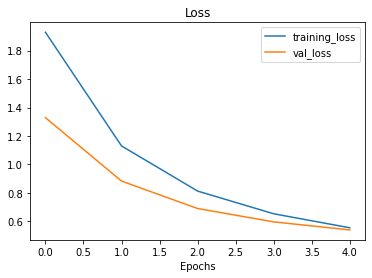

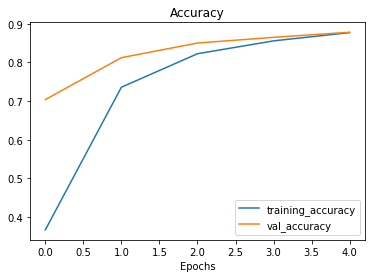

In [ ]:
plot_loss_curves(history_10_percent)

Trying out different kinds of model on 10 percent data and comparing to above base model

# model_1:
Use feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-02-01 21:11:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   204MB/s    in 0.6s    

2023-02-01 21:11:15 (204 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir1="10_food_classes_1_percent/test"

In [ ]:
IMAGE_SIZE=(224,224)
bs=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir1,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from keras import layers
from keras import preprocessing

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


In [ ]:
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D()(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)

model_1=tf.keras.Model(inputs,outputs)

NameError: ignored

In [ ]:
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

NameError: ignored

In [ ]:
history_1_percent=model_1.fit(train_data_1_percent,epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data")])

Saving TensorBoard log files to: transfer_learning/1_percent_data/20230201-211139
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4215 - accuracy: 0.0429 - val_loss: 2.3484 - val_accuracy: 0.1234
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1540 - accuracy: 0.2000 - val_loss: 2.2389 - val_accuracy: 0.2007
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9908 - accuracy: 0.3429 - val_loss: 2.1268 - val_accuracy: 0.2467
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7661 - accuracy: 0.5429 - val_loss: 2.0226 - val_accuracy: 0.3109
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6397 - accuracy: 0.5857 - val_loss: 1.9238 - val_accuracy: 0.3602


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.9305 - accuracy: 0.3700


[1.9304701089859009, 0.3700000047683716]

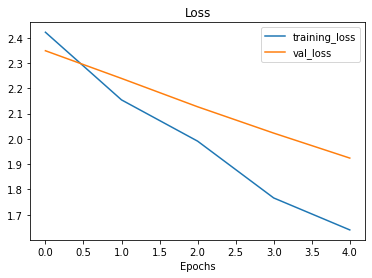

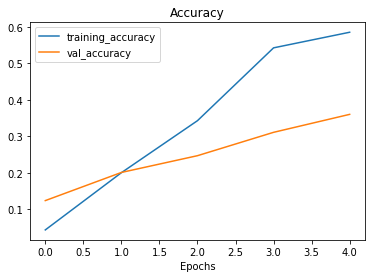

In [ ]:
plot_loss_curves(history_1_percent)

Model checkpoint callback

# model_2
Use feature extraction transfer learning on 10% of the training data with data augmentation.

In [ ]:
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir_10percent="10_food_classes_10_percent/test"


In [ ]:
IMAGE_SIZE=(224,224)
bs=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_10percent,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras as keras
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D()(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)

model_2=tf.keras.Model(inputs,outputs)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
checkpoint_path="tmp/checkpoint.ckpt"
checkpoint_callbacks=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           save_weights_only=True,
                                           save_best_only=False,
                                           save_freq="epoch",
                                           verbose=1)

In [ ]:
history_2=model_2.fit(train_data_10_percent,epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data2"),checkpoint_callbacks])

Saving TensorBoard log files to: transfer_learning/10_percent_data2/20230201-211218
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.3587
Epoch 1: saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 19s 537ms/step - loss: 2.0014 - accuracy: 0.3587 - val_loss: 1.4842 - val_accuracy: 0.6694
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.6533
Epoch 2: saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 11s 453ms/step - loss: 1.3749 - accuracy: 0.6533 - val_loss: 1.0483 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0433 - accuracy: 0.7453
Epoch 3: saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 11s 452ms/step - loss: 1.0433 - accuracy: 0.7453 - val_loss: 0.8324 - val_accuracy: 0.7961
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8904 - accuracy: 0.7867
Epoch 4: savi

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6625 - accuracy: 0.8308


[0.6624808311462402, 0.8307999968528748]

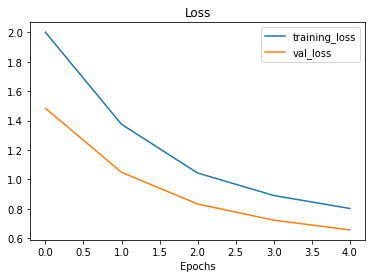

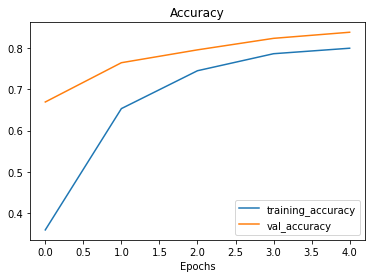

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6625 - accuracy: 0.8308


[0.6624806523323059, 0.8307999968528748]

# model 3
 Use fine-tuning transfer learning on 10% of the training data with data augmentation.

In [ ]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f50f659a310> True
<keras.engine.sequential.Sequential object at 0x7f50e26c85b0> True
<keras.engine.functional.Functional object at 0x7f50e23536d0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f51502124c0> True
<keras.layers.core.dense.Dense object at 0x7f50f66a2c10> True


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [ ]:
fine_tune_epochs=10

histroy_3=model_2.fit(train_data_10_percent,epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                      initial_epoch=history_2.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_fine_tune last 10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune last 10/20230201-211350
Epoch 5/10
24/24 [==============================] - 19s 494ms/step - loss: 0.6806 - accuracy: 0.7987 - val_loss: 0.5486 - val_accuracy: 0.8289
Epoch 6/10
24/24 [==============================] - 9s 347ms/step - loss: 0.5497 - accuracy: 0.8293 - val_loss: 0.5187 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 10s 385ms/step - loss: 0.5029 - accuracy: 0.8587 - val_loss: 0.4887 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 8s 331ms/step - loss: 0.4435 - accuracy: 0.8573 - val_loss: 0.4615 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 8s 321ms/step - loss: 0.3945 - accuracy: 0.8800 - val_loss: 0.4949 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 8s 326ms/step - loss: 0.3542 - accuracy: 0.9067 - val_loss: 0.4723 - val_accuracy: 0.8372


In [ ]:
result_finetune=model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4685 - accuracy: 0.8464


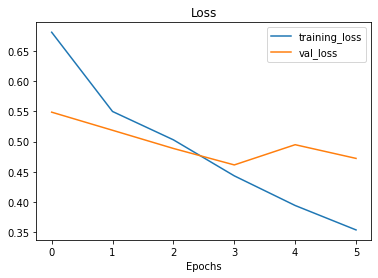

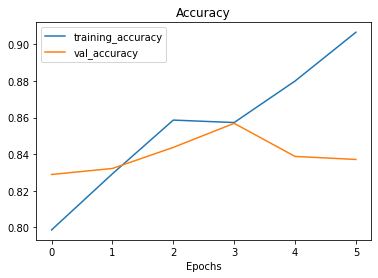

In [ ]:
plot_loss_curves(histroy_3)

In [ ]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.35866665840148926, 0.653333306312561, 0.7453333139419556, 0.7866666913032532, 0.800000011920929, 0.7986666560173035, 0.8293333053588867, 0.8586666584014893, 0.8573333621025085, 0.8799999952316284, 0.9066666960716248]


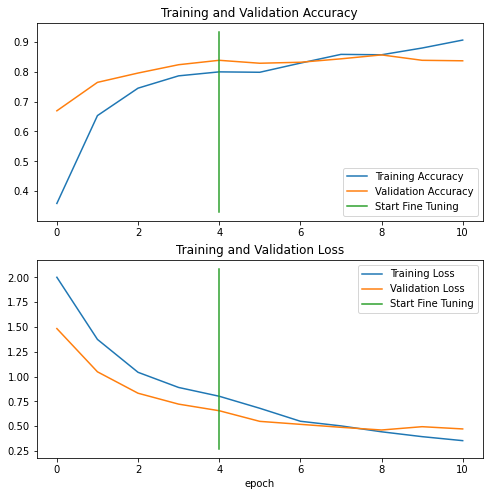

In [ ]:
compare_historys(history_2,histroy_3)

# model_4
Use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-02-01 21:15:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   176MB/s    in 2.8s    

2023-02-01 21:15:11 (176 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
train_dir_100_percent="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [ ]:
IMAGE_SIZE=(224,224)
bs=32
train_data_100_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_100_percent,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMAGE_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=bs)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
for i,layer in enumerate(model_2.layers):
  print(i,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d_1 True
4 output_layer True


In [ ]:

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [ ]:
fine_tune_epochs=10

histroy_4=model_2.fit(train_data_100_percent,epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data_100_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                      initial_epoch=history_2.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_fine_tune_all_data")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_all_data/20230201-211517
Epoch 5/10
235/235 [==============================] - 65s 249ms/step - loss: 0.6958 - accuracy: 0.7769 - val_loss: 0.3720 - val_accuracy: 0.8783
Epoch 6/10
235/235 [==============================] - 52s 221ms/step - loss: 0.5750 - accuracy: 0.8141 - val_loss: 0.3353 - val_accuracy: 0.8865
Epoch 7/10
235/235 [==============================] - 48s 203ms/step - loss: 0.5095 - accuracy: 0.8356 - val_loss: 0.2719 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 47s 197ms/step - loss: 0.4577 - accuracy: 0.8519 - val_loss: 0.2918 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 44s 184ms/step - loss: 0.4319 - accuracy: 0.8581 - val_loss: 0.2750 - val_accuracy: 0.9112
Epoch 10/10
235/235 [==============================] - 41s 172ms/step - loss: 0.4008 - accuracy: 0.8688 - val_loss: 0.2677 - val_accuracy: 0.9161


In [ ]:
result_m4=model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.3303 - accuracy: 0.8940


6
12
[0.7986666560173035, 0.8293333053588867, 0.8586666584014893, 0.8573333621025085, 0.8799999952316284, 0.9066666960716248, 0.7769333124160767, 0.81413334608078, 0.8356000185012817, 0.8518666625022888, 0.8581333160400391, 0.8687999844551086]


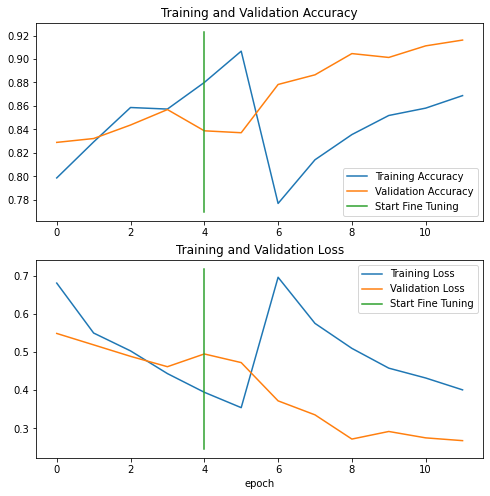

In [ ]:
compare_historys(histroy_3,histroy_4)

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

# Uploading the tensorboard dev website

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiments with Food101 classes." \
 --description "A series of different transfer learning experiments with varying amount of data and finetuning." \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=eghWjwmsWn8LLitSVK9w7tcdjrGkRg&prompt=consent&access_type=o